<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/main/%5BPractice%5D_05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

**Model we will use:** This time we will use models within `tf.keras.applications` and apply them to our own problem. (recognizing food images)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!nvidia-smi

Fri May 28 10:22:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

🟢 [Important] 🔽
Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [3]:
!wget https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py

--2021-05-28 10:22:42--  https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-28 10:22:42 (82.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# import helper function we will use in this script 🟢 [Important] 🔽
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## Get the data

In [5]:
# download and unzip our 10% 10 classes food data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-05-28 10:22:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  16.0MB/s    in 10s     

2021-05-28 10:22:54 (16.0 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [7]:
# Set up train and test paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


### To load data
🟢 [Important] 🔽   
This time we won't use `ImageDataGenerator`.  
We will use `image_dataset_from_directory()`  
Why?   
`image_dataset_from_directory()` loads data in `tf.data.Dataset` format which is much more handy and is faster.   

In [8]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [9]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [11]:
# Check class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 12.642858    4.642857    1.6428572]
   [ 12.97449     4.9744897   1.9744899]
   [ 14.857143    6.857143    3.857143 ]
   ...
   [254.40312   247.8422    241.41367  ]
   [251.81125   254.66837   245.52548  ]
   [245.68332   247.96896   230.61179  ]]

  [[ 14.          7.          1.       ]
   [ 14.          7.          1.       ]
   [ 14.285714    7.285714    1.2857141]
   ...
   [255.        253.6379    247.79614  ]
   [251.14798   255.        248.58669  ]
   [242.16798   242.45363   226.93309  ]]

  [[ 17.428572    8.428572    3.4285717]
   [ 15.5         6.5         1.5      ]
   [ 15.214286    6.214286    1.2142859]
   ...
   [251.59688   254.23477   248.50017  ]
   [249.94391   255.        249.51526  ]
   [246.66301   244.07622   231.2343   ]]

  ...

  [[167.4439     48.872425    7.219402 ]
   [169.28067    53.209236    6.4235206]
   [174.96925    59.39783     7.7549734]
   ...
   [250.16835   141.16835    58.168354 ]
   [247.87242   138.87242    53.872425 ]
   [2

In [13]:
tf.reduce_max(images[0]), tf.reduce_min(images[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=255.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

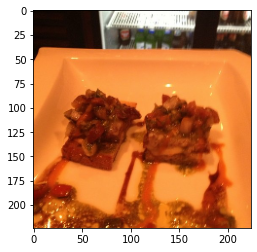

In [14]:
plt.imshow(images[0]/255.)

## Model 0: Creating a transfer learning feature extraction model using functional api


In [15]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the weights of base model so that weights are not updated during training
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

# 4. If using ResnNet50V2 you will need to normalize inputs [Not required for efficientnet] (optional)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs to the base model: {x.shape}")

# 6. Average pool the outputs of the base_model (aggregate all the most important info, reduce number of parameters)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              callbacks = [create_tensorboard_callback(
                                            dir_name = "/content/drive/MyDrive/Food_Classification/tensorboard",
                                            experiment_name = "05_model_0_10_percent_feature_extraction")])

Shape after passing inputs to the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_0_10_percent_feature_extraction/20210528-102301
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 497ms/step - loss: 1.8963 - accuracy: 0.4107 - val_loss: 1.3642 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 9s 380ms/step - loss: 1.1408 - accuracy: 0.7467 - val_loss: 0.9536 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - 9s 380ms/step - loss: 0.8429 - accuracy: 0.8000 - val_loss: 0.7897 - val_accuracy: 0.8010
Epoch 4/5
24/24 [==============================] - 10s 387ms/step - loss: 0.6819 - accuracy: 0.8493 - val_loss: 0.6605 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 9s 380ms/step - loss: 0.5937 - accuracy: 0.8573 - val_loss: 0.6372 - val_accuracy: 0.8289


In [16]:
# Evaluate of the full test data
model_0.evaluate(test_data)

79/79 [==============================] - 14s 176ms/step - loss: 0.6053 - accuracy: 0.8424


[0.6053299903869629, 0.8424000144004822]

In [17]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

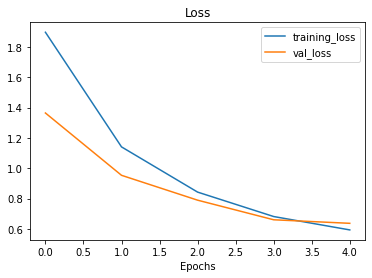

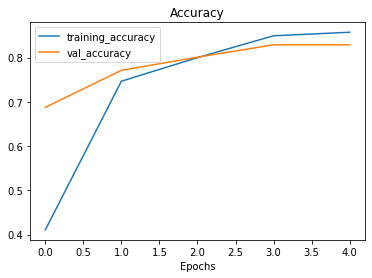

In [20]:
# Check out our model's training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.    

Let's try to visualize it with an example.  
Let's use a (1,4,4,3) tensor and pass it through GlobalAveragePooling2D.


In [21]:
# Define the input shape
temp_input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
temp_input_tensor = tf.random.normal(temp_input_shape)
print(f"Random input tensor:\n {temp_input_tensor}\n")

# Pass the random tensor through global average pooling layer
temp_global_average_pooled = tf.keras.layers.GlobalAveragePooling2D()(temp_input_tensor)
print(f"2D global average pooled tensor:\n {temp_global_average_pooled}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {temp_input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {temp_global_average_pooled.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [22]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(temp_input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

## Model 1: feature extraction transfer learning on 1% of the training data with data augmentation

### Getting and preprocessing data for model_1

In [23]:
# downloading the data for experiment 1 - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-05-28 10:24:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  56.3MB/s    in 2.3s    

2021-05-28 10:24:19 (56.3 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [24]:
# Specify train and test path
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [25]:
# Inspect data
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [26]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [27]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           batch_size = BATCH_SIZE,
                                                                           image_size = IMAGE_SIZE,
                                                                           label_mode = 'categorical')
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           batch_size = BATCH_SIZE,
                                                                           image_size = IMAGE_SIZE,
                                                                           label_mode = 'categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
* Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.
  
Using `tensorflow.keras.layers.experimental.preprocessing`.  

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [29]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation_layer = keras.Sequential([
                    preprocessing.RandomFlip('horizontal'),
                    preprocessing.RandomRotation(0.2),
                    preprocessing.RandomZoom(0.2),
                    preprocessing.RandomHeight(0.2),
                    preprocessing.RandomWidth(0.2),
                    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but Efficientnet has rescaling builtin
], name = "data_augmentation_layer")

### Visualize augmentations using our data_augmentation layer

In [30]:
# View a random image and compare it with augmented version [Add to helper_functions]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
def get_image_augmentations(data, dir_name):
  target_class = random.choice(data.class_names)
  target_dir = dir_name + "/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image

  # Read and plot original random image
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  plt.title(f"Original random image from class: {target_class}")
  plt.axis(False)

  # Read and plot augmented random image
  augmented_img = data_augmentation_layer(tf.expand_dims(img, axis = 0))
  plt.figure()
  plt.imshow(tf.squeeze(augmented_img)/255.)
  plt.title(f"Augmented random image from class: {target_class}")
  plt.axis(False);


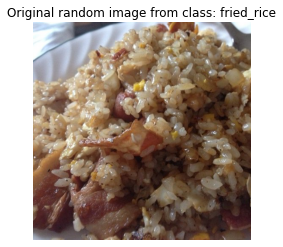

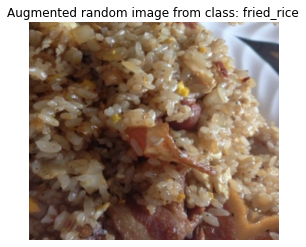

In [31]:
get_image_augmentations(train_data_1_percent, train_dir_1_percent)

### Create model 1 using functional API and add data augmentation layer to it

🟢  [Important] : base_model(x, training=False) 🔽   
We set `training = False` in `base_model(x, training=False)` so that we pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated.   
This is very important. As they are the only exceptions, **Batch_norm layers shouldnot be unfrozen even during fine tuning.**: https://keras.io/guides/transfer_learning/#build-a-model 


In [32]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape = INPUT_SHAPE, name = 'input_layer')

# Add data augmentation layer
x = data_augmentation_layer(inputs)

# Give base_model inputs after augmenting them and don't train it
x = base_model(x, training = False)

# Pool the output features of the base_model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Add the output layer (dense layer)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_data_1_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_1_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              # Track training logs
                              callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                                       experiment_name = '05_model_1_1_percent_data_aug_feature_extraction')])


Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_1_1_percent_data_aug_feature_extraction/20210528-102425
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 16s 5s/step - loss: 2.3983 - accuracy: 0.0429 - val_loss: 2.2204 - val_accuracy: 0.1645
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1793 - accuracy: 0.1429 - val_loss: 2.1053 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9990 - accuracy: 0.2571 - val_loss: 1.9754 - val_accuracy: 0.3520
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8120 - accuracy: 0.5714 - val_loss: 1.8828 - val_accuracy: 0.4359
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6470 - accuracy: 0.6000 - val_loss: 1.8052 - val_accuracy: 0.4704


In [33]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
# Evaluate on all test images
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 14s 172ms/step - loss: 1.8029 - accuracy: 0.4780


[1.8029155731201172, 0.4779999852180481]

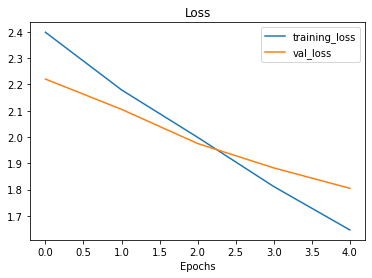

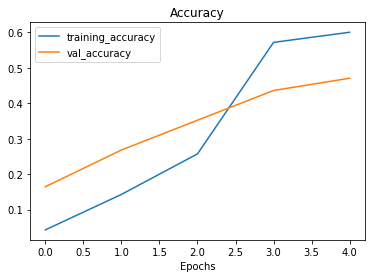

In [35]:
plot_loss_curves(model_1_history)

## Model 2: feature extraction transfer learning on 10% of the training data with data augmentation

In [36]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2021-05-28 10:25:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   106MB/s    in 1.5s    

2021-05-28 10:25:31 (106 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [37]:
# Set up directories

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [38]:
import tensorflow as tf
IMAGE_SHAPE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SHAPE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this.
# test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
#                                                                 label_mode="categorical",
#                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.


In [39]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [40]:
# Create model 2 same as model 1 (with data augmentation)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Build data augmentation layer
data_augmentation_layer = tf.keras.Sequential([
                          preprocessing.RandomFlip('horizontal'),
                          preprocessing.RandomRotation(0.2),
                          preprocessing.RandomZoom(0.2),
                          preprocessing.RandomHeight(0.2),
                          preprocessing.RandomWidth(0.2),
                          # preprocessing.Rescaling(1./255) 
], name = 'data_augmentation_layer')

# Setup input shape
INPUT_SHAPE = (224,224,3)
# Build our base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Assemble the model
inputs = layers.Input(shape = INPUT_SHAPE, name = 'input_layer')
x = data_augmentation_layer(inputs)
x = base_model(x, training = False) # pass augmented images to base model but keep it in inference mode, so batch_norm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])



### Building a model checkpoint callback

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains. 


In [41]:
# Set up checkpoint path
checkpoint_path = '10_percent_model_checkpoint_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      save_weights_only = True,
                                                      save_best_only = True,
                                                      save_freq = 'epoch',
                                                      verbose = 1
                                                      )

In [42]:
# Fit the model add checkpoint callback
INITIAL_EPOCHS = 5
model_2_history = model_2.fit(train_data_10_percent,
                  epochs = INITIAL_EPOCHS,
                  steps_per_epoch = len(train_data_10_percent),
                  validation_data = test_data,
                  validation_steps = int(0.25 * len(test_data)),
                  callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                          experiment_name = '05_model_2_10_percent_data_aug_feature_extraction'),
                              checkpoint_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_2_10_percent_data_aug_feature_extraction/20210528-102537
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 27s 846ms/step - loss: 1.9639 - accuracy: 0.3707 - val_loss: 1.4924 - val_accuracy: 0.6168

Epoch 00001: val_loss improved from inf to 1.49243, saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 1.3166 - accuracy: 0.6760 - val_loss: 1.0754 - val_accuracy: 0.7451

Epoch 00002: val_loss improved from 1.49243 to 1.07543, saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 17s 683ms/step - loss: 1.0388 - accuracy: 0.7347 - val_loss: 0.8807 - val_accuracy: 0.7763

Epoch 00003: val_loss improved from 1.07543 to 0.88071, saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 16s 656ms/step - loss: 0.8938 - accuracy: 0.7733 - val_loss: 0.7863 - val_accuracy: 0.8043

Epoch 00004: val_loss improved from 0.88071 to 0.78633, saving model t

In [43]:
# Compare model_0 results with model_2 on all test data
model_0.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.6053 - accuracy: 0.8424


[0.6053299307823181, 0.8424000144004822]

In [44]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug


79/79 [==============================] - 14s 172ms/step - loss: 0.6774 - accuracy: 0.8196


[0.677413284778595, 0.819599986076355]

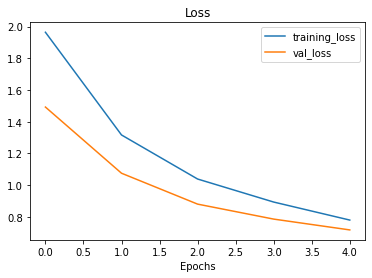

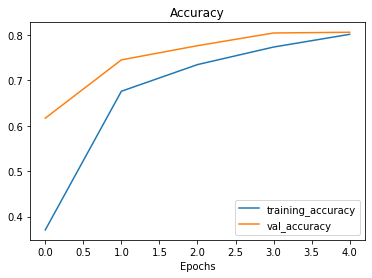

In [45]:
plot_loss_curves(model_2_history)

In [46]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [47]:
loaded_results_10_percent_data_aug = model_2.evaluate(test_data)
loaded_results_10_percent_data_aug

79/79 [==============================] - 14s 170ms/step - loss: 0.6774 - accuracy: 0.8196


[0.6774134635925293, 0.819599986076355]

In [48]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_results_10_percent_data_aug

False

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

However, they should be very close...

In [49]:
# Check to see if loaded model results are very close to native model results (should output True) [Important]
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_results_10_percent_data_aug))

array([ True,  True])

In [50]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_results_10_percent_data_aug))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning transfer learning on 10% of the training data with data augmentation.  
> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data.


In [51]:
# layers in our loaded model
model_2.load_weights(checkpoint_path)

In [52]:
model_2.layers

In [53]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f96232531d0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f957de3c710> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f95d6b7f950> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f95d64a4710> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f95d6abde10> True


In [54]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for idx, layer in enumerate(model_2.layers[2].layers):
  print(idx, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
# How many trainable variables are there in our base model
print(len(model_2.layers[2].trainable_variables))

0


To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [56]:
base_model.trainable = True

# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model each time you make a change
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine tuning you typically want to lower the lr by 10%
                metrics = ['accuracy'])

> 🤔 **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).  
  
When fine tuning it is a rule of thumb to lower the learning rate by 10x.  
We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.  

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).


In [57]:
# Now check which layers are trainable
for idx, layer in enumerate(model_2.layers[2].layers):
  print(idx, layer.name, layer.trainable) 

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [58]:
# Now we have unfrozen some of the layers at the top. Let's check how many trainable variables are there
print(len(model_2.layers[2].trainable_variables))

10


We have already trained our final layer of model_2 using feature extraction. Now, the next step is to fine-tune on some epochs.

In [59]:
# Fine tune for another 5 epochs
FINE_TUNE_EPOCHS = INITIAL_EPOCHS + 5

# Refit the model (same as model_2, except with more trainable layers)
model_3_history = model_2.fit(train_data_10_percent,
                              steps_per_epoch = len(train_data_10_percent),
                              epochs = FINE_TUNE_EPOCHS,
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              initial_epoch = model_2_history.epoch[-1], # start training from previous last epoch [Important]
                              callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                          experiment_name = '05_model_3_10_percent_data_aug_fine_tune')]
                              )

Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_3_10_percent_data_aug_fine_tune/20210528-102757


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
24/24 [==============================] - 26s 817ms/step - loss: 0.6592 - accuracy: 0.8093 - val_loss: 0.5805 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - 16s 669ms/step - loss: 0.5417 - accuracy: 0.8373 - val_loss: 0.5468 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 15s 620ms/step - loss: 0.4896 - accuracy: 0.8453 - val_loss: 0.5595 - val_accuracy: 0.8158
Epoch 8/10
24/24 [==============================] - 14s 581ms/step - loss: 0.4482 - accuracy: 0.8627 - val_loss: 0.4971 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 14s 571ms/step - loss: 0.3970 - accuracy: 0.8867 - val_loss: 0.5387 - val_accuracy: 0.8224
Epoch 10/10
24/24 [==============================] - 16s 646ms/step - loss: 0.3628 - accuracy: 0.8893 - val_loss: 0.5111 - val_accuracy: 0.8322


In [60]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.4979 - accuracy: 0.8332


In [61]:
results_10_percent_data_aug

[0.677413284778595, 0.819599986076355]

### Compare the histories of model_2 before and after fine tuning

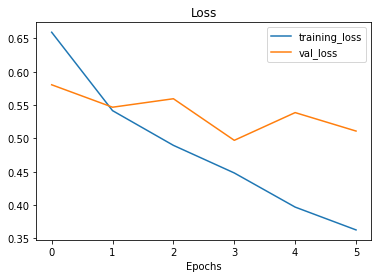

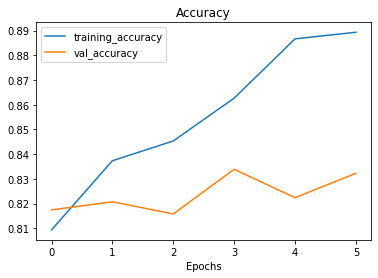

In [62]:
plot_loss_curves(model_3_history)

Need to update plot_lost_curves function as it is not suited for comparing one series of running fit to another. Eg. before and after fine tuning.

In [63]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs = 5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']


  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training_Accuracy")
  plt.plot(total_val_acc, label = "Validation Accuracy")
  plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

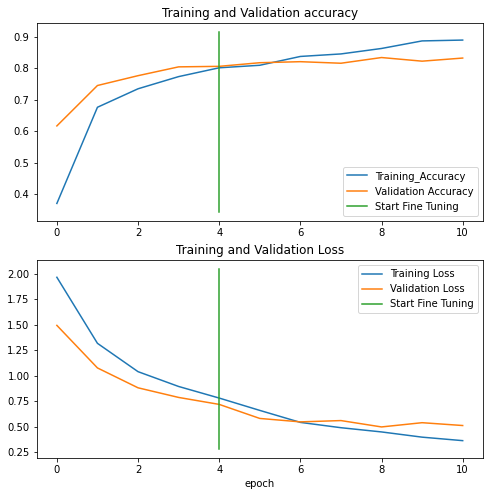

In [64]:
compare_histories(model_2_history, model_3_history)

## Model 4: Fine-tuning an existing model all of the data

In [65]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-05-28 10:30:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   119MB/s    in 4.7s    

2021-05-28 10:30:09 (105 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [66]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [67]:
# Set up data inputs
IMAGE_SIZE = (224,224)
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                     label_mode = 'categorical', 
                                                                     image_size = IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                     label_mode = 'categorical', 
                                                                     image_size = IMAGE_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is same as what e have been using for previous experiments. Let's verify this.

In [68]:
# Evaluate model 2 (model 3 version: fine tune on 10 percent data version)
model_2.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.4979 - accuracy: 0.8332


[0.49786749482154846, 0.8331999778747559]

In [69]:
results_fine_tune_10_percent

[0.49786749482154846, 0.8331999778747559]

Both are same hence same data.

To fine tune model_4 we need to revert our model_2 to before fine tune version.  
This will help us in comparing it with model_3.  
This can be done by reloading weights from checkpoint.

In [70]:
# Revert model_2 to checkpoint weights
model_2.load_weights(checkpoint_path)

In [71]:
# Verify that model_2 has reverted to before fine tune by evaluating on test data
model_2.evaluate(test_data)

79/79 [==============================] - 14s 170ms/step - loss: 0.6774 - accuracy: 0.8196


[0.6774136424064636, 0.819599986076355]

In [72]:
results_10_percent_data_aug

[0.677413284778595, 0.819599986076355]

Since both the above are same, hence it has been reverted back.

In [74]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for idx, layer in enumerate(model_2.layers):
  print(idx, layer.name, layer.trainable)
# We see that they still remain trainable even after reloading weights

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [73]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for idx, layer in enumerate(model_2.layers[2].layers):
  print(idx, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Now that we have model with trainable layers. Now let's recompile the model.

In [75]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                metrics = ['accuracy'])

In [78]:
FINE_TUNE_EPOCHS = INITIAL_EPOCHS + 5
model_4_history = model_2.fit(train_data_all,
                              steps_per_epoch = len(train_data_all),
                              epochs = FINE_TUNE_EPOCHS,
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              initial_epoch = model_2_history.epoch[-1],
                              callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                          experiment_name = '05_model_4_all_data_aug_fine_tune')]
                              )

Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_4_all_data_aug_fine_tune/20210528-110939
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 78s 303ms/step - loss: 0.7236 - accuracy: 0.7693 - val_loss: 0.3528 - val_accuracy: 0.8849
Epoch 6/10
235/235 [==============================] - 89s 378ms/step - loss: 0.5824 - accuracy: 0.8131 - val_loss: 0.3209 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 82s 345ms/step - loss: 0.5170 - accuracy: 0.8299 - val_loss: 0.3073 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 75s 317ms/step - loss: 0.4728 - accuracy: 0.8472 - val_loss: 0.3010 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 77s 328ms/step - loss: 0.4406 - accuracy: 0.8559 - val_loss: 0.2764 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 73s 309ms/step - loss: 0.4083 - accuracy: 0.8685 - val_loss: 0.2731 - val_accuracy: 0.9095


In [79]:
# Evaluate model_4 (model_2 fine tuned on all data) on all test data
results_fine_tune_all_data = model_2.evaluate(test_data)
result_fine_tune_all_data

79/79 [==============================] - 14s 170ms/step - loss: 0.2975 - accuracy: 0.9044


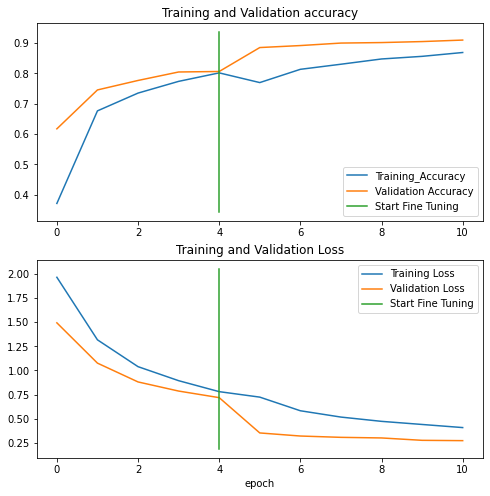

In [80]:
# How did fine-tuning go with more data?
compare_histories(model_2_history, model_4_history, initial_epochs = 5)

## Visualize our experiment data on tensorboard

In [81]:
# View tensorboard logs of transfer learning modeling experiments
! tensorboard dev upload --logdir /content/drive/MyDrive/Food_Classification/tensorboard \
  --name "Transfer Learning Experiments with 10 Food 101 classes"\
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2021-05-28 11:28:50.737088: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/Food_Classification/tensorboard

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&red

In [82]:
!tensorboard dev list

2021-05-28 11:31:29.435763: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/zEeuQaYWRIy7hPe16FWnUA/
	Name                 Transfer Learning Experiments with 10 Food 101 classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   zEeuQaYWRIy7hPe16FWnUA
	Created              2021-05-28 11:29:27 (2 minutes ago)
	Updated              2021-05-28 11:31:25 (9 seconds ago)
	Runs                 66
	Tags                 7
	Scalars              978
	Tensor bytes         0
	Binary object bytes  37988623
https://tensorboard.dev/experiment/i5srmLg9QLiZ0DKV3dZ0wQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Desc

In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id zEeuQaYWRIy7hPe16FWnUA